### SQLite Geographic Data Visualization

In [2]:
!pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.5 MB/s eta 0:00:00


In [3]:
import sqlite3
import pandas as pd
import numpy as np
import datetime
import random
import matplotlib.pyplot as plt
import seaborn as sns
from faker import Faker

# Initialize faker for generating realistic patient data
fake = Faker()

# Create database connection
conn = sqlite3.connect('healthcare_monitoring.db')
cursor = conn.cursor()

# Create patients table
cursor.execute('''
CREATE TABLE IF NOT EXISTS patients (
    patient_id INTEGER PRIMARY KEY,
    mrn TEXT UNIQUE NOT NULL,
    first_name TEXT NOT NULL,
    last_name TEXT NOT NULL,
    date_of_birth TEXT NOT NULL,
    gender TEXT NOT NULL,
    blood_type TEXT,
    admission_date TEXT NOT NULL,
    primary_diagnosis TEXT NOT NULL,
    insurance_provider TEXT,
    attending_physician TEXT NOT NULL
)
''')

# Create vital_signs table
cursor.execute('''
CREATE TABLE IF NOT EXISTS vital_signs (
    record_id INTEGER PRIMARY KEY,
    patient_id INTEGER NOT NULL,
    timestamp TEXT NOT NULL,
    temperature REAL,
    heart_rate INTEGER,
    blood_pressure_systolic INTEGER,
    blood_pressure_diastolic INTEGER,
    respiratory_rate INTEGER,
    oxygen_saturation INTEGER,
    pain_level INTEGER,
    FOREIGN KEY (patient_id) REFERENCES patients (patient_id)
)
''')

# Create medications table
cursor.execute('''
CREATE TABLE IF NOT EXISTS medications (
    medication_id INTEGER PRIMARY KEY,
    patient_id INTEGER NOT NULL,
    medication_name TEXT NOT NULL,
    dosage TEXT NOT NULL,
    route TEXT NOT NULL,
    frequency TEXT NOT NULL,
    start_date TEXT NOT NULL,
    end_date TEXT,
    prescribing_physician TEXT NOT NULL,
    FOREIGN KEY (patient_id) REFERENCES patients (patient_id)
)
''')

# Create lab_results table
cursor.execute('''
CREATE TABLE IF NOT EXISTS lab_results (
    result_id INTEGER PRIMARY KEY,
    patient_id INTEGER NOT NULL,
    test_name TEXT NOT NULL,
    test_date TEXT NOT NULL,
    result_value REAL,
    unit TEXT,
    reference_range TEXT,
    is_abnormal INTEGER,
    notes TEXT,
    FOREIGN KEY (patient_id) REFERENCES patients (patient_id)
)
''')

conn.commit()

In [6]:
# Generate sample patient data
diagnoses = [
    "Hypertension", "Type 2 Diabetes", "Congestive Heart Failure",
    "Pneumonia", "COPD", "Stroke", "Myocardial Infarction",
    "Asthma", "Kidney Disease", "Gastroenteritis"
]

blood_types = ["A+", "A-", "B+", "B-", "AB+", "AB-", "O+", "O-"]

insurance_providers = [
    "Medicare", "Medicaid", "Blue Cross", "Aetna",
    "UnitedHealth", "Cigna", "Humana", "Kaiser"
]

physicians = [
    "Dr. Smith", "Dr. Johnson", "Dr. Williams", "Dr. Brown",
    "Dr. Jones", "Dr. Garcia", "Dr. Miller", "Dr. Davis",
    "Dr. Rodriguez", "Dr. Martinez"
]

# Generate patients
patients_data = []
for i in range(1, 101):  # 100 patients
    mrn = f"MRN{i:06d}"
    first_name = fake.first_name()
    last_name = fake.last_name()

    # Generate date of birth between 18 and 90 years ago
    dob = fake.date_of_birth(minimum_age=18, maximum_age=90).strftime('%Y-%m-%d')

    gender = random.choice(["Male", "Female"])
    blood_type = random.choice(blood_types)

    # Admission date within the last year
    admission_date = fake.date_between(start_date="-1y", end_date="today").strftime('%Y-%m-%d')

    primary_diagnosis = random.choice(diagnoses)
    insurance_provider = random.choice(insurance_providers)
    attending_physician = random.choice(physicians)

    patients_data.append((
        i, mrn, first_name, last_name, dob, gender, blood_type,
        admission_date, primary_diagnosis, insurance_provider, attending_physician
    ))

cursor.executemany(
    "INSERT OR IGNORE INTO patients VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)",
    patients_data
)
conn.commit()

# Generate vital signs data
vital_signs_data = []
record_id = 1  # Initialize record_id

for patient_id in range(1, 101):
    # Generate between 10-30 vital sign records per patient
    num_records = random.randint(10, 30)

    # ... (rest of your code to generate vital signs data) ...

cursor.executemany(
    "INSERT INTO vital_signs VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)",
    vital_signs_data
)
conn.commit()

# Get the last record_id and increment by 1
cursor.execute("SELECT MAX(record_id) FROM vital_signs")
last_record_id = cursor.fetchone()[0]
if last_record_id is not None:
    record_id = last_record_id + 1
else:
    record_id = 1  # If table is empty, start from 1

cursor.executemany(
    "INSERT INTO vital_signs VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)",
    vital_signs_data
)
conn.commit()

In [11]:
# Generate medication data
medications = [
    "Lisinopril", "Metformin", "Atorvastatin", "Amlodipine", "Metoprolol",
    "Albuterol", "Levothyroxine", "Gabapentin", "Omeprazole", "Losartan",
    "Simvastatin", "Hydrochlorothiazide", "Pantoprazole", "Furosemide", "Citalopram"
]

dosages = ["10mg", "20mg", "25mg", "50mg", "75mg", "100mg", "250mg", "500mg", "1000mg"]
routes = ["Oral", "IV", "IM", "Sublingual", "Topical", "Inhalation"]
frequencies = ["Once daily", "Twice daily", "Three times daily", "Every 4 hours", "Every 6 hours", "As needed"]

medication_data = []
medication_id = 1

# Get current date for calculations
today = datetime.datetime.now().date()
one_month_ago = today - datetime.timedelta(days=30)
one_year_ago = today - datetime.timedelta(days=365)

for patient_id in range(1, 101):
    # Generate between 1-5 medications per patient
    num_medications = random.randint(1, 5)

    for _ in range(num_medications):
        medication_name = random.choice(medications)
        dosage = random.choice(dosages)
        route = random.choice(routes)
        frequency = random.choice(frequencies)

        # Generate start date between 1 month and 1 year ago
        days_ago = random.randint(30, 365)
        start_date = (today - datetime.timedelta(days=days_ago)).strftime('%Y-%m-%d')

        # 70% chance medication is ongoing (no end date)
        if random.random() < 0.7:
            end_date = None
        else:
            # End date between start date and today
            end_days = random.randint(1, days_ago - 1)
            end_date = (today - datetime.timedelta(days=end_days)).strftime('%Y-%m-%d')

        prescribing_physician = random.choice(physicians)

        medication_data.append((
            medication_id, patient_id, medication_name, dosage, route,
            frequency, start_date, end_date, prescribing_physician
        ))

        medication_id += 1

cursor.executemany(
    "INSERT INTO medications VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)",
    medication_data
)
conn.commit()

### 1. Patient Demographics Analysis

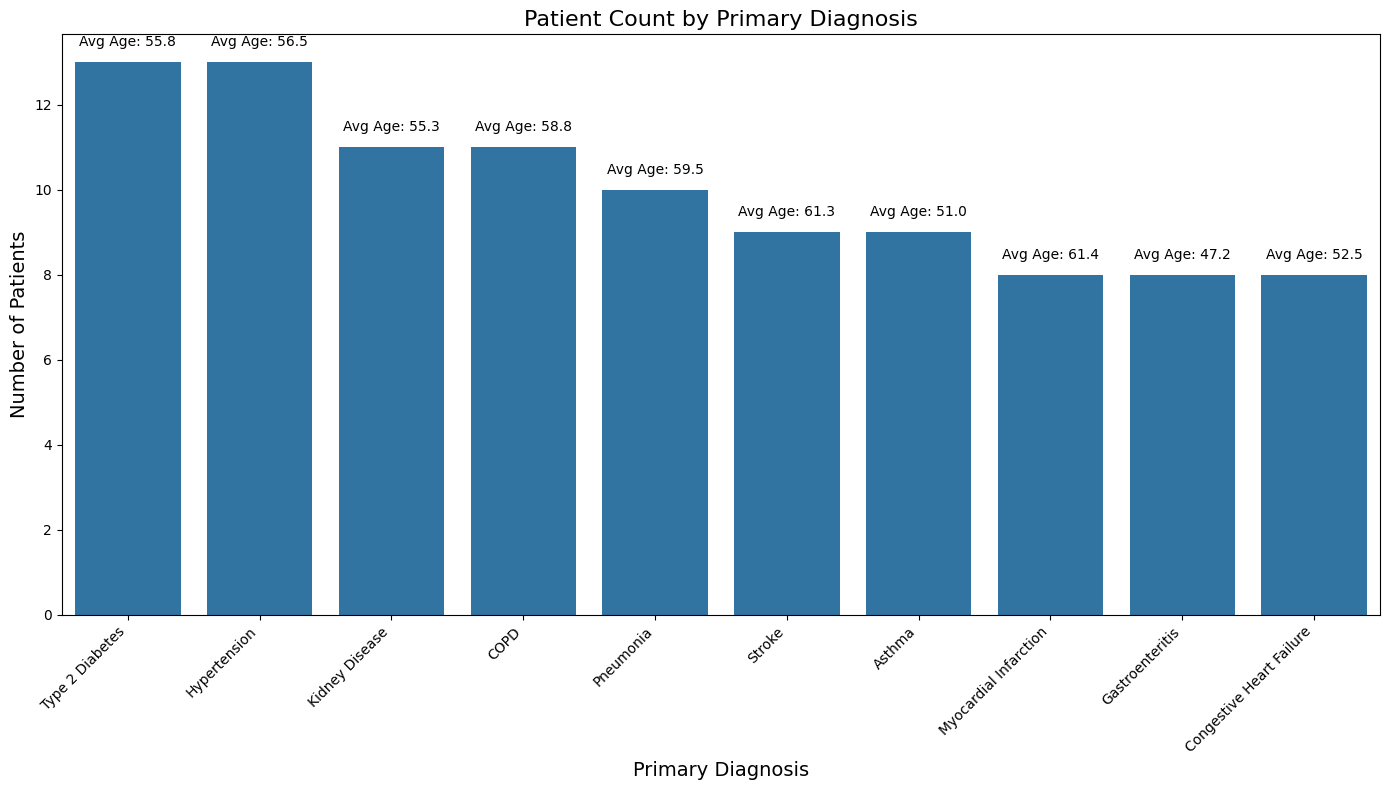

In [12]:
# Query patient demographics
demographics_query = """
SELECT
    primary_diagnosis,
    COUNT(*) as patient_count,
    AVG(CAST(strftime('%Y', 'now') as integer) - CAST(strftime('%Y', date_of_birth) as integer)) as avg_age,
    SUM(CASE WHEN gender = 'Male' THEN 1 ELSE 0 END) as male_count,
    SUM(CASE WHEN gender = 'Female' THEN 1 ELSE 0 END) as female_count
FROM patients
GROUP BY primary_diagnosis
ORDER BY patient_count DESC
"""

demographics_df = pd.read_sql_query(demographics_query, conn)

# Create visualization
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='primary_diagnosis', y='patient_count', data=demographics_df)
ax.set_title('Patient Count by Primary Diagnosis', fontsize=16)
ax.set_xlabel('Primary Diagnosis', fontsize=14)
ax.set_ylabel('Number of Patients', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add age annotations
for i, row in enumerate(demographics_df.itertuples()):
    ax.text(i, row.patient_count + 0.3, f'Avg Age: {row.avg_age:.1f}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('patient_demographics.png', dpi=300)
plt.show()

### 2. Vital Signs Monitoring Dashboard

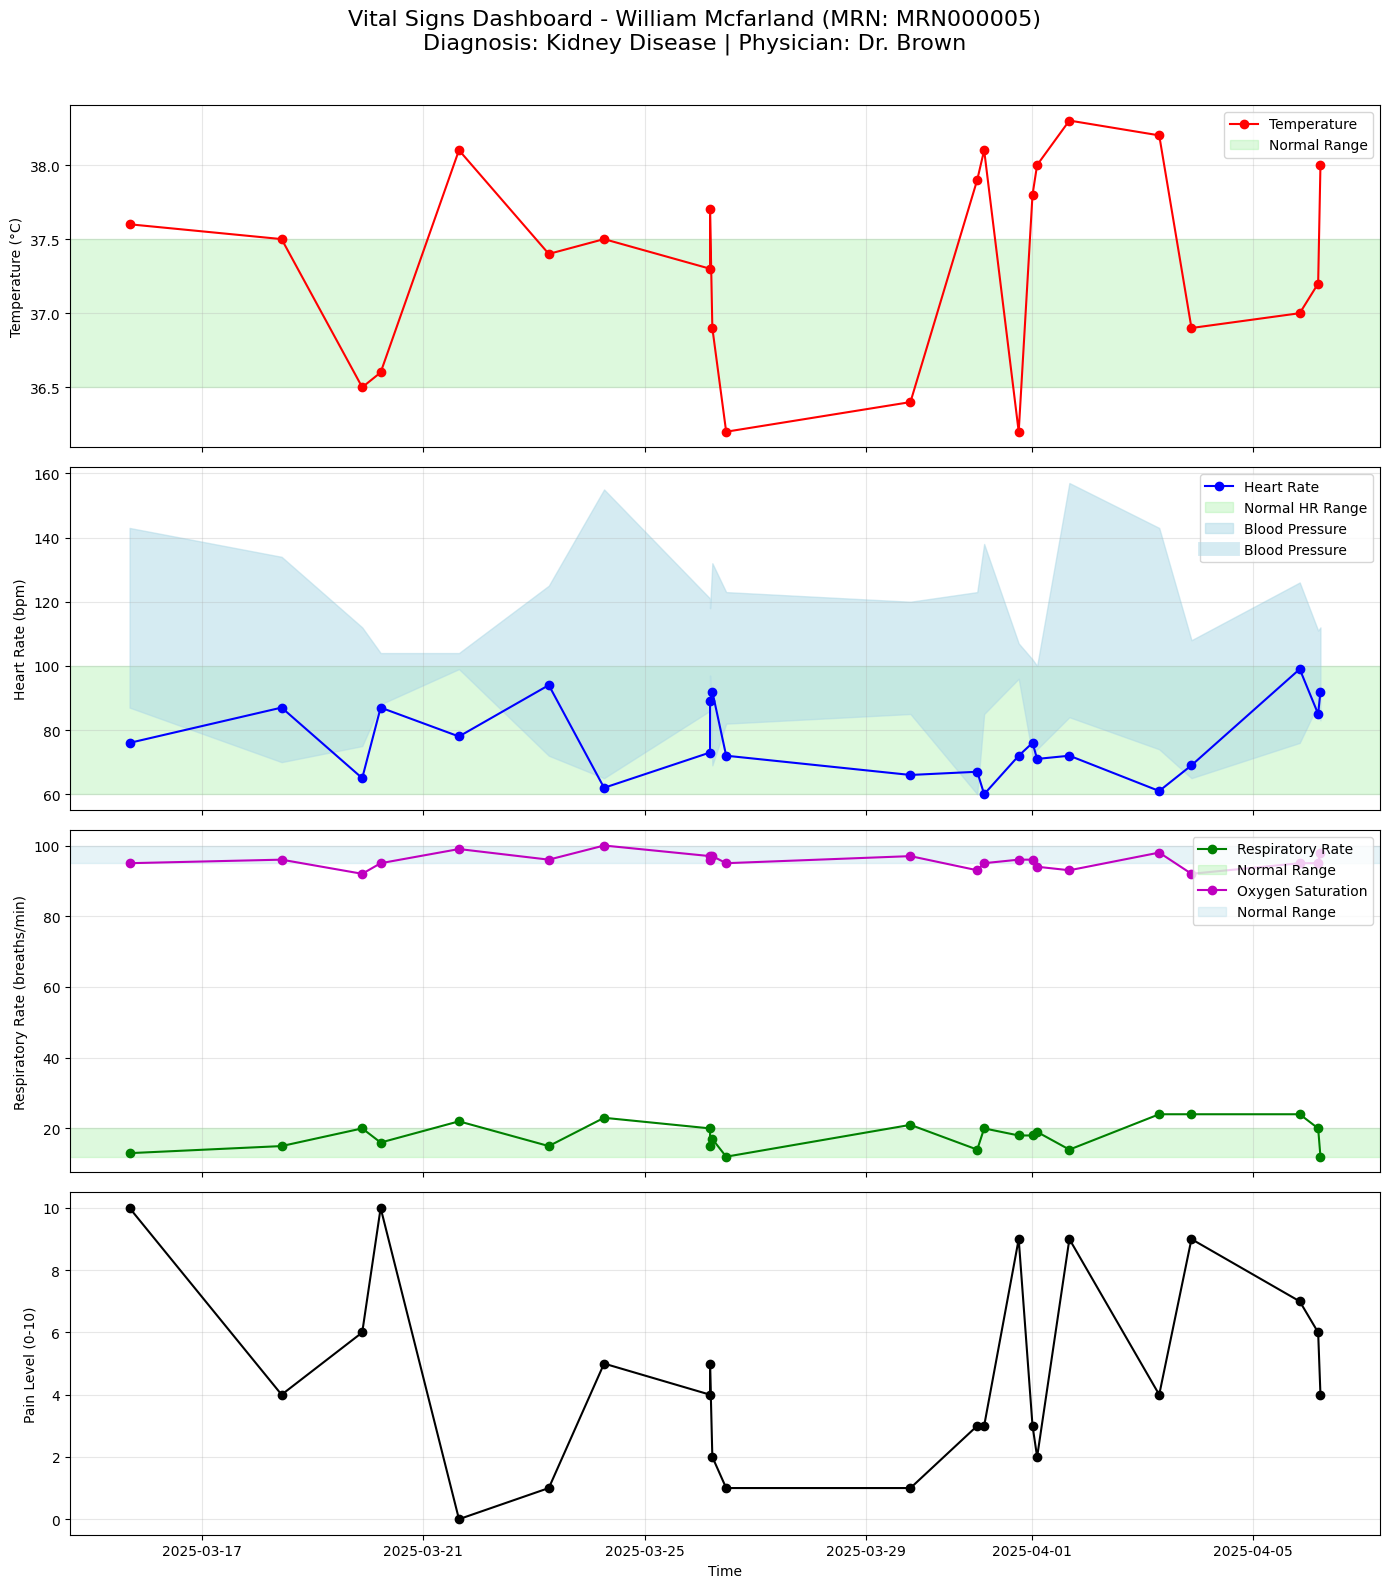

In [13]:
# Query vital signs for a specific patient
patient_id = 5  # Example patient ID

vital_signs_query = f"""
SELECT
    timestamp,
    temperature,
    heart_rate,
    blood_pressure_systolic,
    blood_pressure_diastolic,
    respiratory_rate,
    oxygen_saturation,
    pain_level
FROM vital_signs
WHERE patient_id = {patient_id}
ORDER BY timestamp
"""

vitals_df = pd.read_sql_query(vital_signs_query, conn)
vitals_df['timestamp'] = pd.to_datetime(vitals_df['timestamp'])

# Get patient info
patient_info_query = f"""
SELECT
    mrn,
    first_name || ' ' || last_name as patient_name,
    primary_diagnosis,
    attending_physician
FROM patients
WHERE patient_id = {patient_id}
"""

patient_info = pd.read_sql_query(patient_info_query, conn).iloc[0]

# Create multi-panel vital signs chart
fig, axes = plt.subplots(4, 1, figsize=(14, 16), sharex=True)
fig.suptitle(f"Vital Signs Dashboard - {patient_info['patient_name']} (MRN: {patient_info['mrn']})\nDiagnosis: {patient_info['primary_diagnosis']} | Physician: {patient_info['attending_physician']}",
             fontsize=16, y=0.99)

# Temperature
axes[0].plot(vitals_df['timestamp'], vitals_df['temperature'], 'ro-', label='Temperature')
axes[0].axhspan(36.5, 37.5, color='lightgreen', alpha=0.3, label='Normal Range')
axes[0].set_ylabel('Temperature (°C)')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Heart Rate and Blood Pressure
axes[1].plot(vitals_df['timestamp'], vitals_df['heart_rate'], 'bo-', label='Heart Rate')
axes[1].axhspan(60, 100, color='lightgreen', alpha=0.3, label='Normal HR Range')
axes[1].set_ylabel('Heart Rate (bpm)')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

# Plot blood pressure as a band
axes[1].fill_between(vitals_df['timestamp'],
                    vitals_df['blood_pressure_diastolic'],
                    vitals_df['blood_pressure_systolic'],
                    color='lightblue', alpha=0.5, label='Blood Pressure')
axes[1].plot([], [], color='lightblue', alpha=0.5, linewidth=10, label='Blood Pressure')
axes[1].legend(loc='upper right')

# Respiratory Rate and Oxygen Saturation
axes[2].plot(vitals_df['timestamp'], vitals_df['respiratory_rate'], 'go-', label='Respiratory Rate')
axes[2].axhspan(12, 20, color='lightgreen', alpha=0.3, label='Normal Range')
axes[2].set_ylabel('Respiratory Rate (breaths/min)')
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)

axes[2].plot(vitals_df['timestamp'], vitals_df['oxygen_saturation'], 'mo-', label='Oxygen Saturation')
axes[2].axhspan(95, 100, color='lightblue', alpha=0.3, label='Normal Range')
axes[2].legend(loc='upper right')

# Pain Level
axes[3].plot(vitals_df['timestamp'], vitals_df['pain_level'], 'ko-', label='Pain Level')
axes[3].set_ylabel('Pain Level (0-10)')
axes[3].set_ylim(-0.5, 10.5)  # Fixed scale for pain
axes[3].set_xlabel('Time')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig('patient_vitals_dashboard.png', dpi=300)
plt.show()

### 3. Medication Analysis

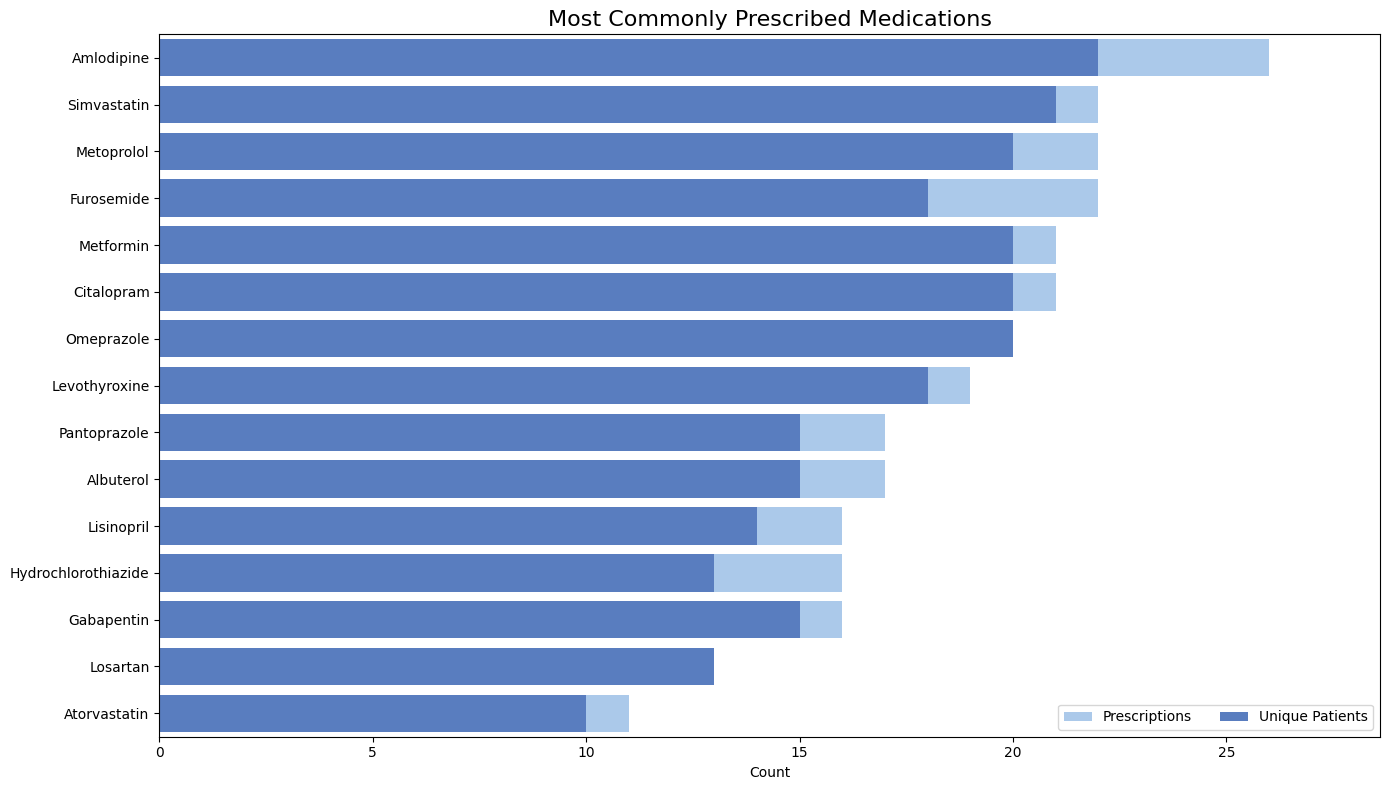

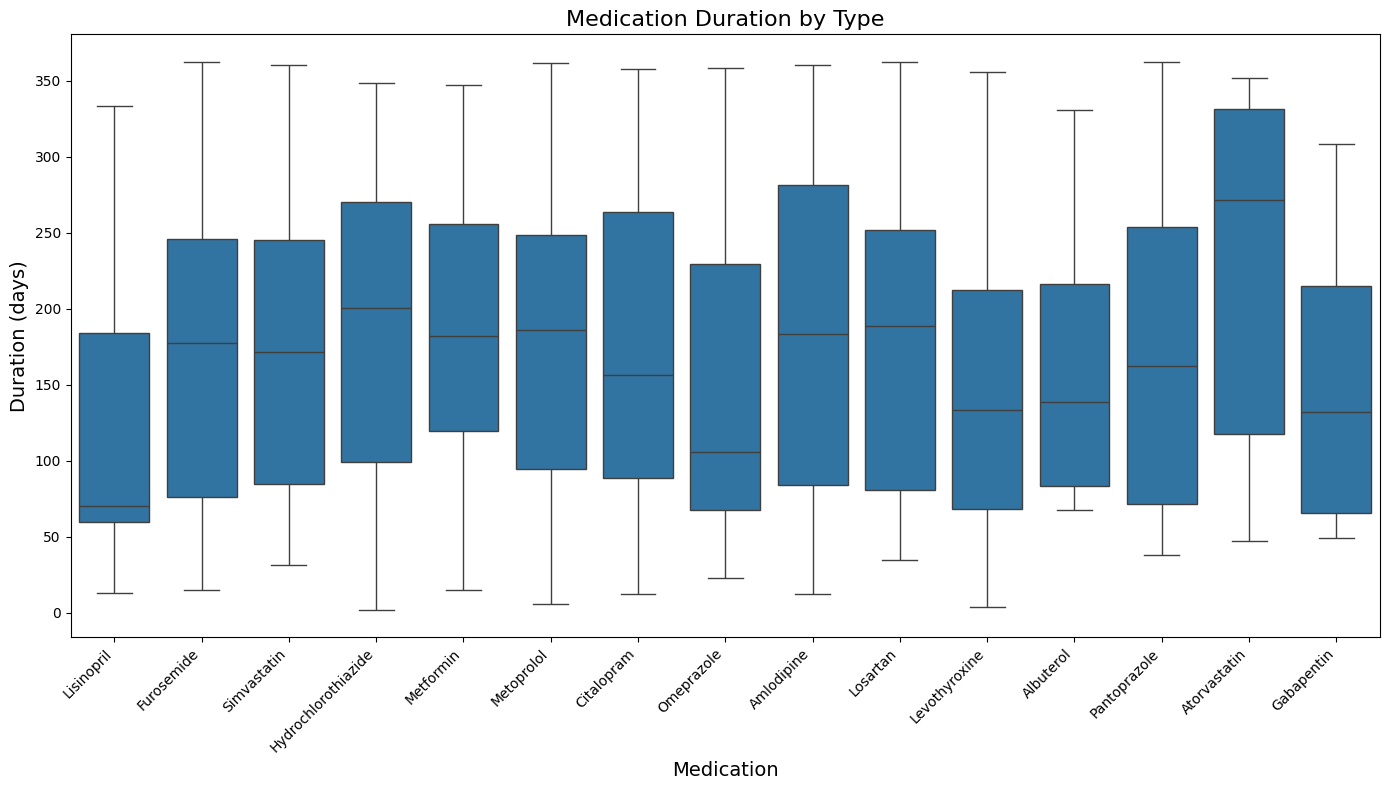

In [14]:
# Query to find most common medications
medication_frequency_query = """
SELECT
    medication_name,
    COUNT(*) as prescription_count,
    COUNT(DISTINCT patient_id) as patient_count
FROM medications
GROUP BY medication_name
ORDER BY prescription_count DESC
"""

medication_freq_df = pd.read_sql_query(medication_frequency_query, conn)

# Create visualization
plt.figure(figsize=(14, 8))
sns.set_color_codes("pastel")
ax = sns.barplot(x='prescription_count', y='medication_name', data=medication_freq_df.head(15), color='b', label='Prescriptions')

# Add a second layer with unique patient count
sns.set_color_codes("muted")
sns.barplot(x='patient_count', y='medication_name', data=medication_freq_df.head(15), color='b', label='Unique Patients')

# Add legend and labels
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, medication_freq_df['prescription_count'].max() * 1.1),
      ylabel="",
      xlabel="Count")
ax.set_title('Most Commonly Prescribed Medications', fontsize=16)

plt.tight_layout()
plt.savefig('medication_frequency.png', dpi=300)
plt.show()

# Medication duration analysis
medication_duration_query = """
SELECT
    medication_name,
    CASE
        WHEN end_date IS NULL THEN julianday('now') - julianday(start_date)
        ELSE julianday(end_date) - julianday(start_date)
    END as duration_days
FROM medications
"""

med_duration_df = pd.read_sql_query(medication_duration_query, conn)

plt.figure(figsize=(14, 8))
ax = sns.boxplot(x='medication_name', y='duration_days', data=med_duration_df)
ax.set_title('Medication Duration by Type', fontsize=16)
ax.set_xlabel('Medication', fontsize=14)
ax.set_ylabel('Duration (days)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('medication_duration.png', dpi=300)
plt.show()